In [1]:
import numpy as np
import pandas as pd


In [2]:
df=pd.read_csv('data/Nat_Gas.csv')
df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


In [4]:
df.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [5]:
df['Dates']=pd.to_datetime(df['Dates'])

/var/folders/vw/wnpxkfbd0td_tthn1f9l3bj00000gp/T/ipykernel_35411/2958409106.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates']=pd.to_datetime(df['Dates'])


In [6]:
import plotly.express as px

fig=px.line(df,x='Dates',y='Prices',title='Natural Gas Prices')
fig.show()

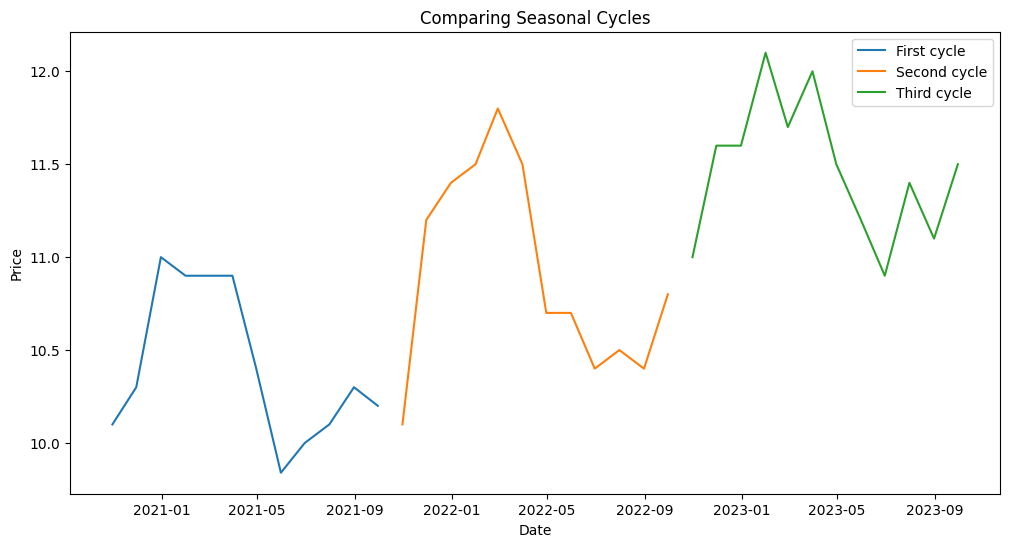

In [7]:
import matplotlib.pyplot as plt

m = 12  # number of months in a year (since your data is monthly)
plt.figure(figsize=(12,6))

# First cycle: 2020-10-31 to 2021-09-30
plt.plot(df['Dates'][:m], df['Prices'][:m], label='First cycle')
# Second cycle: 2021-10-31 to 2022-09-30
plt.plot(df['Dates'][m:2*m], df['Prices'][m:2*m], label='Second cycle')
# Third cycle: 2022-10-31 to 2023-09-30
plt.plot(df['Dates'][2*m:3*m], df['Prices'][2*m:3*m], label='Third cycle')
plt.legend()
plt.title("Comparing Seasonal Cycles")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


i can see that there is a seasonality where the prices go up in december, january, feb and march and it starts going down where there is also a repetitive behavior where it goes to the minimum in may, jun, july and august and then starts to go up again

i also notice an upward trend on the whole timeline where the prices are actually going up within the four years. 


In [8]:
# Select the first 12 months (assuming monthly data) and describe the Prices
first_year_prices = df[df['Dates'] < '2022-01-01']
first_year_prices.describe()

,Dates,Prices
count,15,15.000000
mean,2021-05-31 09:36:00,10.509333
min,2020-10-31 00:00:00,9.840000
25%,2021-02-14 00:00:00,10.100000
50%,2021-05-31 00:00:00,10.300000
75%,2021-09-15 00:00:00,10.900000
max,2021-12-31 00:00:00,11.400000
std,NaN,0.490939


In [9]:
last_year_prices = df[df['Dates'] >= '2024-01-01']
last_year_prices.describe()

,Dates,Prices
count,9,9.000000
mean,2024-05-31 00:00:00,11.955556
min,2024-01-31 00:00:00,11.400000
25%,2024-03-31 00:00:00,11.500000
50%,2024-05-31 00:00:00,11.800000
75%,2024-07-31 00:00:00,12.400000
max,2024-09-30 00:00:00,12.700000
std,NaN,0.507718


# Natural Gas purchase price estimation

1- set date as index for time series interpolation 



In [10]:
df.set_index('Dates',inplace=True)


2- Interpolating the price data for any missing date between the given monthly prices 


In [11]:
df_interpolated=df.resample('D').interpolate('linear')

In [12]:
df_interpolated

,Prices
Dates,
2020-10-31,10.100000
2020-11-01,10.106667
2020-11-02,10.113333
2020-11-03,10.120000
2020-11-04,10.126667
...,...
2024-09-26,11.760000
2024-09-27,11.770000
2024-09-28,11.780000


# Extrapolate future prices using a simple time series model 

In [13]:
train_data=df_interpolated[:'2023-12-31']
test_data=df_interpolated['2024-01-01':]


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
mae=mean_absolute_error(test_data['Prices'],predicted_data['Predicted_Prices'])
mse=mean_squared_error(test_data['Prices'],predicted_data['Predicted_Prices'])
rmse=np.sqrt(mse)
r2=r2_score(test_data['Prices'],predicted_data['Predicted_Prices'])
mape=mean_absolute_percentage_error(test_data['Prices'],predicted_data['Predicted_Prices'])
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}, MAPE: {mape}")

NameError: name 'predicted_data' is not defined

In [26]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Prices'], mode='lines', name='Actual Prices'))
fig.add_trace(go.Scatter(x=predicted_data.index, y=predicted_data['Predicted_Prices'], mode='lines', name='Predicted Prices'))
fig.update_layout(title='Actual vs Predicted Natural Gas Prices',
                  xaxis_title='Date',
                  yaxis_title='Price')
fig.show()

In [27]:
# Autoregressive models


# IMPORTANT: After running the above line, restart the kernel and run this cell again from here.

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

# Fit auto_arima function to the interpolated price data
stepwise_fit = auto_arima(df_interpolated['Prices'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-10053.619, Time=16.06 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-1469.625, Time=0.36 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=6.49 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=8.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-1459.016, Time=0.20 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-10014.616, Time=3.06 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=16.35 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-10067.989, Time=13.80 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=34.34 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=33.26 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=-8922.729, Time=15.37 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=-11897.091, Time=37.24 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=-11893.512, Time=7.73 sec
 ARIMA(2,0,1)(1,1,2)[12] intercept   : AIC=-11876.662, Time=34.79 sec
 ARIMA(2,0,1)(1,1,1)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1431
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood                5972.682
Date:                              Wed, 13 Aug 2025   AIC                         -11933.363
Time:                                      18:05:38   BIC                         -11901.817
Sample:                                  10-31-2020   HQIC                        -11921.579
                                       - 09-30-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9099      0.016    119.410      0.000       1.879       1.941
ar.L2         -0.9155      0.016    -57.483      0.000      -0.947      -0.884
ma.L1          0.1401      0.034      4.165      0.000       0.074       0.206
ma.L2          0.1176      0.042      2.809      0.005       0.036       0.200
ma.S.L12      -0.6899      0.018    -38.146      0.000      -0.725      -0.654
sigma2      1.275e-05   1.47e-07     86.591      0.000    1.25e-05     1.3e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             56798.10
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.17
Prob(H) (two-sided):                  0.84   Kurtosis:                        33.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
best_order = stepwise_fit.order            # (p,d,q)
best_seasonal_order = stepwise_fit.seasonal_order  # (P,D,Q,m)
print(f"Best order: {best_order}, Best seasonal order: {best_seasonal_order}")

Best order: (2, 0, 2), Best seasonal order: (0, 1, 1, 12)


In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Fit the SARIMAX model
model = SARIMAX(train_data['Prices'], order=best_order, seasonal_order=best_seasonal_order,trend='t')
model_fit = model.fit()

NameError: name 'best_order' is not defined

In [30]:
predictions=model_fit.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)
predicted_data = pd.DataFrame({'Predicted_Prices': predictions}, index=test_data.index) 

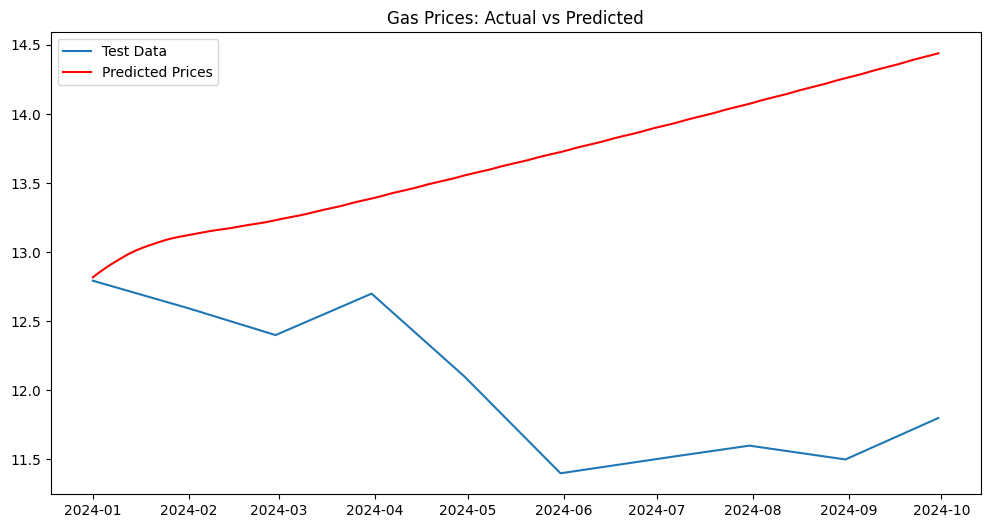

In [31]:
#plot predictions against actual prices
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
#plt.plot(train_data.index, train_data['Prices'], label='Train Data')
plt.plot(test_data.index, test_data['Prices'], label='Test Data')
plt.plot(predicted_data.index, predicted_data['Predicted_Prices'], label='Predicted Prices', color='red')
plt.legend()
plt.title('Gas Prices: Actual vs Predicted')
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
mae=mean_absolute_error(test_data['Prices'],predicted_data['Predicted_Prices'])
mse=mean_squared_error(test_data['Prices'],predicted_data['Predicted_Prices'])
rmse=np.sqrt(mse)
r2=r2_score(test_data['Prices'],predicted_data['Predicted_Prices'])
mape=mean_absolute_percentage_error(test_data['Prices'],predicted_data['Predicted_Prices'])
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}, MAPE: {mape}")                     

MAE: 1.6522897962120517, MSE: 3.535682376098109, RMSE: 1.880341026542289, R2: -13.579007602992771, MAPE: 0.1407791277034751


In [33]:
best_model=ExponentialSmoothing(train_data['Prices'], trend='add',damped_trend=True, seasonal='add',seasonal_periods=365, initialization_method="legacy-heuristic", use_boxcox=False)
best_model_fit=best_model.fit()

In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


#Generate future dates for the next year (12 months)
future_dates=pd.date_range(start=df_interpolated.index[-1],periods=365,freq='d')

#Forecast future prices for 12 months
future_prices=best_model_fit.forecast(steps=365)

#create a dataframe for future prices
future_df=pd.DataFrame({'Dates':future_dates, 'Prices':future_prices})
future_df.set_index('Dates',inplace=True)

future_df

,Prices
Dates,
2024-09-30,12.794840
2024-10-01,12.787666
2024-10-02,12.781550
2024-10-03,12.775671
2024-10-04,12.769900
...,...
2025-09-25,12.642651
2025-09-26,12.665232
2025-09-27,12.687812


In [35]:
def estimate_gas_price(input_date):
    
    #check if date is in the past or present
    if input_date in df_interpolated.index:
        return df_interpolated.loc[input_date]['Prices']
    
    #check if the date is in the future (within the extrapolated range )
    elif input_date in future_df.index:
        return future_df.loc[input_date]['Prices']
    else:
        return "Date is out of range for estimation"
    

In [36]:
input_date='2025-09-15'
price_estimate=estimate_gas_price(input_date)
print(f"Estimated price on {input_date}: {price_estimate}")

Estimated price on 2025-09-15: 12.416844696167347


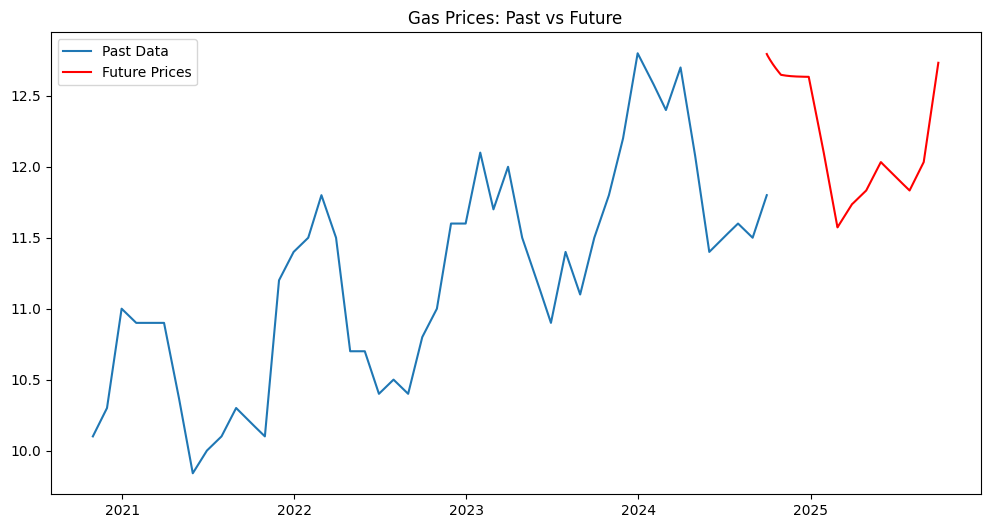

In [37]:
#plot predictions against actual prices
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
#plt.plot(train_data.index, train_data['Prices'], label='Train Data')
plt.plot(df_interpolated.index, df_interpolated['Prices'], label='Past Data')
plt.plot(future_df.index, future_df['Prices'], label='Future Prices', color='red')
plt.legend()
plt.title('Gas Prices: Past vs Future')
plt.show()

FROM HERE

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

models = {"Exponential Smoothing": ExponentialSmoothing,"SARIMAX": SARIMAX}
params={"Exponential Smoothing": {
                    'trend':['add', 'mul'],
                    'damped_trend':[True, False],
                    'seasonal':['add', 'mul'],
                    'seasonal_periods':[365],
                    'initialization_method':["legacy-heuristic", 'estimated','heuristic',None],
                    'use_boxcox':[False, True]
                },
        "SARIMAX": {
                    'order': (2, 0, 2),
                    'seasonal_order': (0, 1, 1, 12)

                }
                }

In [17]:
train_data=df_interpolated[:'2023-12-31']['Prices']
test_data=df_interpolated['2024-01-01':]['Prices']

In [18]:
from itertools import product

results = {}
report = {}
i=1

for model_name, model_class in models.items():
    if model_name == "Exponential Smoothing":

        param_grid = params[model_name]
        keys, values = zip(*param_grid.items())
        for v in product(*values):
            param_dict = dict(zip(keys, v))


            try:
                model = model_class(train_data, **param_dict)
                model_fit = model.fit()
                pred = model_fit.forecast(steps=len(test_data))
                predicted_data = pd.DataFrame({'Predicted_Prices': pred}, index=test_data.index)
                mape = mean_absolute_percentage_error(test_data, pred)
                r2= r2_score(test_data, pred)
                print(f"Model: {model_name}, MAPE: {mape}, Params: {param_dict}")
                #save all models reports

                report[f"{model_name}_{i}"] = {"class": model_class, "mape": mape,"r2":r2, "params": param_dict}
                i += 1

            except Exception as e:
                continue
    elif model_name == "SARIMAX":


        try:
                model = model_class(train_data, order=params[model_name]['order'], seasonal_order=params[model_name]['seasonal_order'])
                model_fit = model.fit(disp=False)
                pred = model_fit.forecast(steps=len(test_data))
                predicted_data = pd.DataFrame({'Predicted_Prices': pred}, index=test_data.index)
                mape = mean_absolute_percentage_error(test_data, pred)
                r2= r2_score(test_data, pred)
                print(f"Model: {model_name}, MAPE: {mape}, Params: {param_dict}")
                
                #save all models reports
                report[f"{model_name}_{i}"] = {"class": model_class, "mape": mape, "r2": r2, "params": param_dict}
                i += 1

        except Exception as e:
            continue
    


    

Model: Exponential Smoothing, MAPE: 0.014662456216409, Params: {'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'legacy-heuristic', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.03724401634095469, Params: {'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'legacy-heuristic', 'use_boxcox': True}


/Users/olasuaifan/opt/anaconda3/envs/quant/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Model: Exponential Smoothing, MAPE: 0.05430796879811058, Params: {'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.07290677819731405, Params: {'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.04586163902114372, Params: {'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.10799706411458743, Params: {'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.014662456216409, Params: {'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': Non

/Users/olasuaifan/opt/anaconda3/envs/quant/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Model: Exponential Smoothing, MAPE: 0.06708013627194817, Params: {'trend': 'add', 'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.0701294366051028, Params: {'trend': 'add', 'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.038360811345666, Params: {'trend': 'add', 'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.10508696453826852, Params: {'trend': 'add', 'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.0079300348713607, Params: {'trend': 'add', 'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': None,

/Users/olasuaifan/opt/anaconda3/envs/quant/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Model: Exponential Smoothing, MAPE: 0.1753491683717347, Params: {'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.14489782464547651, Params: {'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.22797649123512106, Params: {'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.23439085947800206, Params: {'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.01980430751641655, Params: {'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method

/Users/olasuaifan/opt/anaconda3/envs/quant/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Model: Exponential Smoothing, MAPE: 0.1519110593172037, Params: {'trend': 'add', 'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.14002411305444817, Params: {'trend': 'add', 'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.20585047439848225, Params: {'trend': 'add', 'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.22796729000699353, Params: {'trend': 'add', 'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.0644380988797864, Params: {'trend': 'add', 'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method'

/Users/olasuaifan/opt/anaconda3/envs/quant/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Model: Exponential Smoothing, MAPE: 0.13790885246044635, Params: {'trend': 'mul', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': False}


/Users/olasuaifan/opt/anaconda3/envs/quant/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Model: Exponential Smoothing, MAPE: 0.7477921168054593, Params: {'trend': 'mul', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.16991996562747672, Params: {'trend': 'mul', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.15123742410713525, Params: {'trend': 'mul', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.008591247063152096, Params: {'trend': 'mul', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': None, 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.052818986068471456, Params: {'trend': 'mul', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': None, '

/Users/olasuaifan/opt/anaconda3/envs/quant/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Model: Exponential Smoothing, MAPE: 0.07000265704093744, Params: {'trend': 'mul', 'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.07030821796323472, Params: {'trend': 'mul', 'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.038481306291817716, Params: {'trend': 'mul', 'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.10600436508578087, Params: {'trend': 'mul', 'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.007936161200135948, Params: {'trend': 'mul', 'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method':

/Users/olasuaifan/opt/anaconda3/envs/quant/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Model: Exponential Smoothing, MAPE: 0.1950181548378058, Params: {'trend': 'mul', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.1514075170474015, Params: {'trend': 'mul', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.257540444315146, Params: {'trend': 'mul', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.2408813833348753, Params: {'trend': 'mul', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.018946517202147697, Params: {'trend': 'mul', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 

/Users/olasuaifan/opt/anaconda3/envs/quant/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Model: Exponential Smoothing, MAPE: 0.160635554451207, Params: {'trend': 'mul', 'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.1445334407071651, Params: {'trend': 'mul', 'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.23120623124927886, Params: {'trend': 'mul', 'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': False}
Model: Exponential Smoothing, MAPE: 0.23417510930545374, Params: {'trend': 'mul', 'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'heuristic', 'use_boxcox': True}
Model: Exponential Smoothing, MAPE: 0.0607973355541529, Params: {'trend': 'mul', 'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 

/Users/olasuaifan/opt/anaconda3/envs/quant/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Model: SARIMAX, MAPE: 0.05063245131336656, Params: {'trend': 'mul', 'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': None, 'use_boxcox': True}


In [19]:
print(report)

{'Exponential Smoothing_1': {'class': <class 'statsmodels.tsa.holtwinters.model.ExponentialSmoothing'>, 'mape': 0.014662456216409, 'r2': 0.8024542574599616, 'params': {'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'legacy-heuristic', 'use_boxcox': False}}, 'Exponential Smoothing_2': {'class': <class 'statsmodels.tsa.holtwinters.model.ExponentialSmoothing'>, 'mape': 0.03724401634095469, 'r2': 0.02460649363661427, 'params': {'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'legacy-heuristic', 'use_boxcox': True}}, 'Exponential Smoothing_3': {'class': <class 'statsmodels.tsa.holtwinters.model.ExponentialSmoothing'>, 'mape': 0.05430796879811058, 'r2': -0.8327980953683389, 'params': {'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 365, 'initialization_method': 'estimated', 'use_boxcox': False}}, 'Exponential Smoothing_4': {'class': <class 'stats

In [20]:
best_model_score=min(report.items(), key=lambda x: x[1]['mape'])[1]['mape']
best_model= min(report.items(), key=lambda x: x[1]['mape'])[1]['class']
#save the best model and parameters  as an object
best_model_params = min(report.items(), key=lambda x: x[1]['mape'])[1]['params']

print(f"Best model: {best_model}, Best model score: {best_model_score}, Best model params: {best_model_params}")    

Best model: <class 'statsmodels.tsa.holtwinters.model.ExponentialSmoothing'>, Best model score: 0.0079300348713607, Best model params: {'trend': 'add', 'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 365, 'initialization_method': 'legacy-heuristic', 'use_boxcox': False}


In [22]:
best_model_instance = best_model(train_data, **best_model_params)
best_model_fit = best_model_instance.fit()


In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


#Generate future dates for the next year (12 months)
future_dates1=pd.date_range(start=df_interpolated.index[-1],periods=365,freq='d')

#Forecast future prices for 12 months
future_prices1=best_model_fit.forecast(steps=365)

#create a dataframe for future prices
future_df1=pd.DataFrame({'Dates':future_dates1, 'Prices':future_prices1})
future_df1.set_index('Dates',inplace=True)

future_df1

,Prices
Dates,
2024-09-30,12.791038
2024-10-01,12.779744
2024-10-02,12.769866
2024-10-03,12.760408
2024-10-04,12.751198
...,...
2025-09-25,12.552453
2025-09-26,12.578434
2025-09-27,12.604415


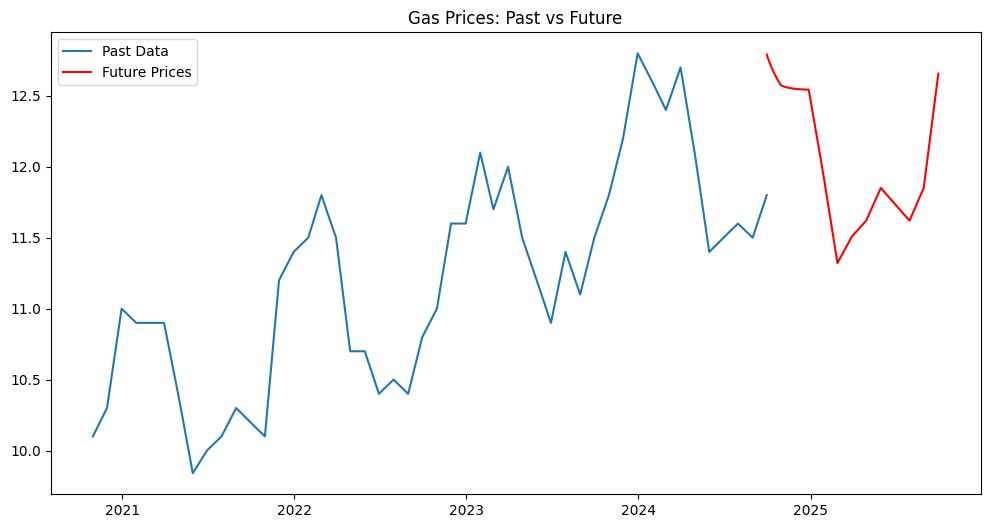

In [25]:
#plot predictions against actual prices
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
#plt.plot(train_data.index, train_data['Prices'], label='Train Data')
plt.plot(df_interpolated.index, df_interpolated['Prices'], label='Past Data')
plt.plot(future_df1.index, future_df1['Prices'], label='Future Prices', color='red')
plt.legend()
plt.title('Gas Prices: Past vs Future')
plt.show()

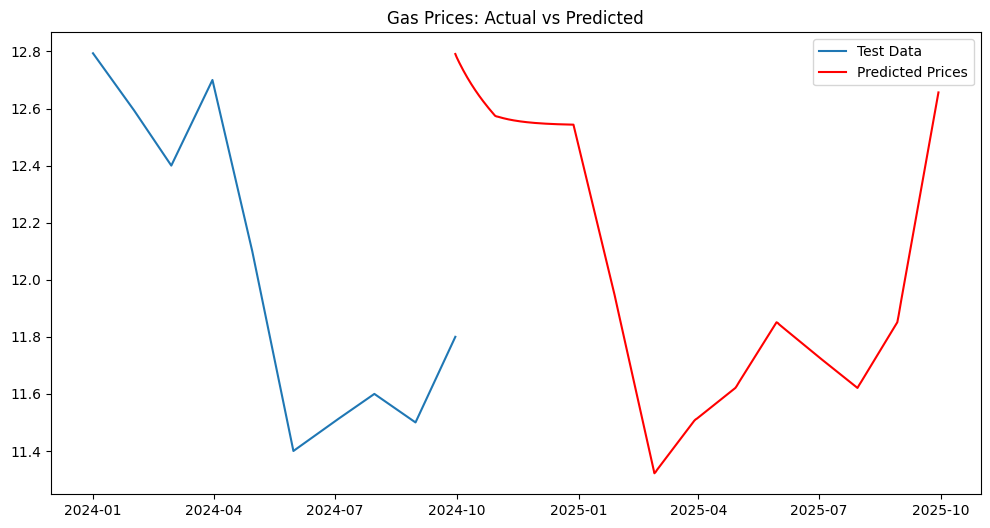

In [29]:
#plot predictions against actual prices
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
#plt.plot(train_data.index, train_data['Prices'], label='Train Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(future_df1.index, future_df1, label='Predicted Prices', color='red')
plt.legend()
plt.title('Gas Prices: Actual vs Predicted')
plt.show()

### Price a commodity storage contract

#Natural gas contract price

value=selling_price-purchase_price-cost

selling_price=sell_price*gas_volume =p*x

purchase_price_cost=gas_volume*purchase_price=l*x

cost=storage_cost +injection_withdrawal_cost+transportation_cost=(g*x)+w+t

storage_cost=storage_fees* storage_months

injection_withdrawal_cost= injection_withdrawal_fees*injection_withrdawl_times

gas_volume<max_storage_volume 


columns/features:

injection_date,	gas_purchase_price_per_unit, entered_amount_(unit),	withdrawl_date,	gas_selling_price_per_unit,	withdrawn_amount_(unit),	injection_withdrawal_fees,	storage_fees_(fixed_per_month),	storage_period_(w-i)_in_months,	storage_max_vol_(fixed_units),	transportation_fees_(fixed),	Final Price 	

If this is just one transaction:

Value= (gas_selling_price_per_unit * withdrawn_amount_(unit)) - (gas_purchase_price_per_unit * entered_amount_(unit)) - injection_withdrawal_fees - ((withdrawl_date - injection_date ) * storage_fees ) - transportation_fees_


If this is just several transactions (this is added everytime a withdrawal happens till withdrawal amount = injected amount)

Value= (gas_selling_price_per_unit * withdrawn_amount_(unit)) - (gas_purchase_price_per_unit * withdrawn_amount_(unit)) - injection_withdrawal_fees - ((withdrawl_date - injection_date ) * storage_fees ) - transportation_fees_



In [68]:
import datetime 
from datetime import date

def contract_price (injection_dates,purchase_prices, injected_amounts, withdrawal_dates, selling_prices, withdrawal_amounts, injection_withdrawal_rate, storage_rate, storage_max_amount, transportation_rate):

    volume=0
    purchase_cost=0
    value=0


    injection_dates = [pd.to_datetime(d) for d in injection_dates]
    withdrawal_dates = [pd.to_datetime(d) for d in withdrawal_dates]
    dates = sorted(injection_dates + withdrawal_dates)


    for i in range(len(dates)):

        if dates[i] in injection_dates:
            volume+=injected_amounts[injection_dates.index(dates[i])]
            if volume > storage_max_amount:
                print("Error, cant inject amount in the storage its more than the storage capacity!")
            else:
                purchase_cost+=(injected_amounts[injection_dates.index(dates[i])] * purchase_prices[injection_dates.index(dates[i])])
                recent_injection_date=dates[i]
                i+=1
        if dates[i] in withdrawal_dates:
            if volume==0 or volume <withdrawal_amounts[withdrawal_dates.index(dates[i])]:
                print("Error, There is no enough quantity to withdraw!, please adjust the withdrawal quantity.")
            else:
                selling=selling_prices[withdrawal_dates.index(dates[i])] * withdrawal_amounts [withdrawal_dates.index(dates[i])]
                storage_period= (dates[i] - recent_injection_date).days //30
                storage_cost=storage_rate * storage_period
                value+=selling-storage_cost-transportation_rate-injection_withdrawal_rate

    final_value=  value - purchase_cost  
    return final_value   
            


In [69]:


injection_dates= ["2024-06-01", "2024-05-04", "2024-04-01", "2024-07-01"] 
purchase_prices =[20, 21, 20.5, 22]
injected_amounts=[10000,5000,10000,1000]
withdrawal_dates=["2024-12-01", "2024-12-15", "2024-11-01", "2024-11-15"] 
selling_prices=[23, 19, 21, 25] 
withdrawal_amounts=[1000,5000,10000,10000]
injection_withdrawal_rate=0.0005  
storage_rate=10000  
storage_max_amount=500000 
transportation_rate=1000


In [75]:
result = contract_price(
	injection_dates,
	purchase_prices,
	injected_amounts,
	withdrawal_dates,
	selling_prices,
	withdrawal_amounts,
	injection_withdrawal_rate,
	storage_rate,
	storage_max_amount,
	transportation_rate
)
print("Contract value:", round(result,2))

Contract value: 31000.0
